In [1]:
# data access

import xarray as xr

In [2]:
# visualisation

from cartopy import crs
import display
import matplotlib.pyplot as plt

In [3]:
PROJECTION = crs.Miller()
area = {"latitude": slice(-5, 5), "longitude": slice(-120, -80)}
el_nino_event_range = ("1997-04", "1998-04")

In [4]:
# data access configuration

dataset = "s3://cmems-reanalysis/cmems_mod_glo_phy_my_0.083_P1D-m.zarr"

In [5]:
ds = xr.open_dataset(dataset, chunks={}, engine="zarr").astype("float32")
ds

/tmp/ipykernel_340/4208247298.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_dataset(dataset, chunks={}, engine="zarr").astype("float32")


<xarray.Dataset>
Dimensions:    (time: 10227, latitude: 2041, longitude: 4320, depth: 50)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-31T12:00:00
Data variables:
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-01-06 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

In [6]:
%%time

zos_pacific_area = ds.zos.sel(**area)
zos_mean = zos_pacific_area.mean(dim="time")
zos_anomaly = zos_pacific_area - zos_mean
zos_anomaly_el_nino_event = zos_anomaly.sel(time=slice(el_nino_event_range[0], el_nino_event_range[1])).mean(dim="time").compute()

CPU times: user 15.4 s, sys: 2.56 s, total: 18 s
Wall time: 8.45 s


/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


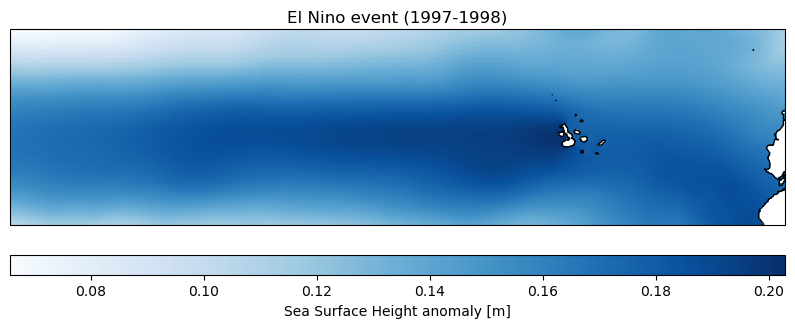

In [7]:
_, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={"projection": PROJECTION},
)
zos_anomaly_el_nino_event.plot(
    ax=ax, 
    cmap="Blues", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Sea Surface Height anomaly [m]"},
)
ax.coastlines()
ax.set_title("El Nino event (1997-1998)")
plt.show()

In [8]:
%%time

el_nino_area_ds = ds.sel(**area)
zos_monthly = el_nino_area_ds.zos.resample(time="1M").mean()
zos_monthly_spatial_mean = zos_monthly.mean(dim=["latitude", "longitude"])
zos_mean = zos_monthly_spatial_mean.mean()
zos_anomaly = (zos_monthly_spatial_mean - zos_mean).compute()

CPU times: user 1min 14s, sys: 3.42 s, total: 1min 18s
Wall time: 55.3 s


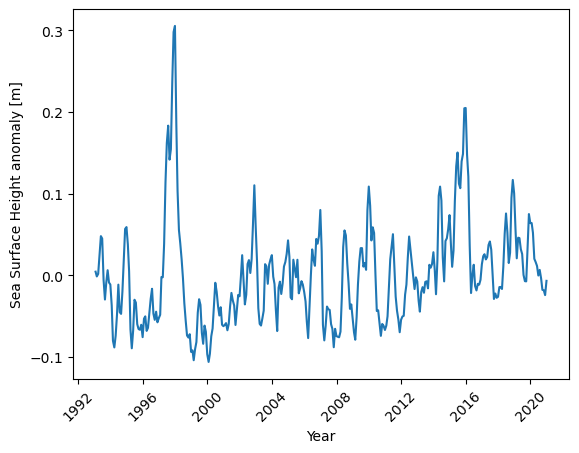

In [9]:
plt.plot(zos_anomaly['time'], zos_anomaly)
plt.xlabel('Year')
plt.ylabel('Sea Surface Height anomaly [m]')
plt.xticks(rotation=45)
plt.show()